In [16]:
##calculate exponential fits from data, plot results, and calculate 1/e lengths

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib import colors as clrs
import matplotlib as mpl
import pandas as pd
%matplotlib inline

import glob
import os.path
import random
import csv

from scipy.optimize import curve_fit
from scipy.optimize import minimize
import numpy as np
from sklearn.metrics import r2_score

plt.rcParams.update({
    'font.size': 26,  
    'text.color': 'black',  
    'xtick.labelsize': 26, 
    'ytick.labelsize': 26,  
    'legend.fontsize': 26, 
    'axes.labelsize': 26,  
})

time_conversion = 24 * 60 # 24 hours * 60 minutes
growth_rate = 210 #210 micron per day

In [2]:
##some commands to suppress warnings
import warnings
warnings.filterwarnings("ignore", 
                        category=RuntimeWarning, 
                        message="overflow encountered in scalar divide")
warnings.filterwarnings("ignore", 
                        category=RuntimeWarning, 
                        message="overflow encountered in exp")

In [3]:
def get_info_spatial(file):
    data = {}  
    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile)
        headers = next(reader)  
    
        for row in reader:
            distance = row[0]  
            values = row[1:]

            data[float(distance)] = [float(value) for value in values]
            
    original_keys = sorted(data.keys())

    depth = 4.  # 4 micron from the skeleton surface
    num_bins = len(original_keys) 
    bin_dict = {key: np.linspace(0, depth, num_bins)[int(key) - 1] for key in original_keys}   
    new_data = {bin_dict[key]: [value for value in values if value > 0.] for key, 
                  values in data.items()}
    
    medians = {}  
    std_devs = {}
    for distance, values in new_data.items():
        median_value = np.mean(values)
        medians[distance] = median_value
        
        std_deviation = np.std(values)
        std_devs[distance] = std_deviation
    return new_data, medians, std_devs

In [4]:
def get_info_temporal(file):
    data = {}  
    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile)
        headers = next(reader)  
    
        for row in reader:
            distance = row[0]  
            values = row[1:]

            data[float(distance)] = [float(value) for value in values]
            
    original_keys = sorted(data.keys())

    depth = 4.  # 4 micron from the skeleton surface
    num_bins = len(original_keys) 
    bin_dict = {key: np.linspace(0, depth, num_bins)[int(key) - 1] for key in original_keys}
    converted_bin_dict = {key: (value / growth_rate) * time_conversion for key, value in bin_dict.items()} 
    new_data = {converted_bin_dict[key]: [value for value in values if value > 0.] for key, 
                  values in data.items()}
    
    medians = {}  
    std_devs = {}
    for distance, values in new_data.items():
        median_value = np.mean(values)
        medians[distance] = median_value
        
        std_deviation = np.std(values)
        std_devs[distance] = std_deviation
    return new_data, medians, std_devs

In [5]:
def exponential_decay_function(x, a, b, c):
    return a * np.exp(-b * x) + c

In [6]:
def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

In [7]:
def make_exp_fit_pre(x_data, y_data, sample_name):
    x_data[0] = 0.01  
    a_range = np.linspace(0.001, 1, 10)
    b_range = np.linspace(-1., 4., 20)
    c_range = np.linspace(0.001, 1., 20)
    best_r2 = -np.inf  
    best_params = None
    best_fit = None

    for a in a_range:
        for b in b_range:
            for c in c_range:
                try:
                    
                    params, covariance = curve_fit(exponential_decay_function, x_data, y_data, 
                                                   p0=[a, b, c], bounds=([0, -np.inf, 0], [1, np.inf, 1]))
                    y_fit_exp = exponential_decay_function(x_data, *params)
                    r2_exp = r2_score(y_data, y_fit_exp)

                    
                    if r2_exp > best_r2:
                        best_r2 = r2_exp
                        best_params = params
                        best_fit = y_fit_exp
                        best_loss_function = 'exp'

                except Exception as e:
                    print(f"An error occurred: {e}")  
                    pass  
    
    print(f'Best R^2 for exponential fit: {best_r2}')
    print(f'Best parameters for exponential fit: {best_params}')
    return best_fit, best_params, best_r2

In [8]:
def make_exp_fit_arag1(x_data, y_data):
    def loss_function(params, x, y):
        a, b, c = params
        y_pred = exponential_decay_function(x, a, b, c)
        mse = np.mean((y - y_pred) ** 2)
        return mse

    a_range = np.linspace(0.001, 1, 10)
    b_range = np.linspace(0.001, 0.2, 10)
    c_range = np.linspace(0.001, 0.2, 10)
    
    best_r2_exp = -np.inf
    best_params_exp = None
    
    for a in a_range:
        #print(a)
        for b in b_range:
            
            for c in c_range:
                try:
                    bounds = [(None, None), (None, None), (None, None)]  # No bounds for a and c

                    res = minimize(loss_function, x0=[a,b,c], args=(x_data, y_data), 
                    method='Nelder-Mead')
                    params = res.x
                    y_fit = exponential_decay_function(x_data, *params)
                    r2_exp = r2_score(y_data, y_fit)
                    if r2_exp > best_r2_exp:
                        best_r2_exp = r2_exp
                        best_params_exp = params
                except Exception as e:
                    print(e)
                    pass  # Handle exception if needed
    
    print(f'Best R^2 for exponential fit: {best_r2_exp}')
    print(f'Best parameters for exponential fit: {best_params_exp}')
    y_data = exponential_decay_function(x_data,*best_params_exp)
    return y_data, best_params_exp, best_r2_exp

def make_exp_fit_arag2(x_data, y_data):
    def loss_function(params, x, y):
        a, b, c = params
        y_pred = a * np.exp(-b * x) + c
        # Assign higher weights to points on the left side of the curve
        weights = np.exp(-x)
        mse = np.mean(weights * (y - y_pred) ** 2)
        return mse

    a_range = np.linspace(0.001, 1, 10)
    b_range = np.linspace(0.001, 0.2, 10)
    c_range = np.linspace(0.001, 0.2, 10)
    
    best_r2_exp = -np.inf
    best_params_exp = None
    
    for a in a_range:
        #print(a)
        for b in b_range:
            
            for c in c_range:
                try:

                    bounds = [(None, None), 
                              (None, None), 
                              (None, None)]  # No bounds for a and c

                    res = minimize(loss_function, x0=[a,b,c], args=(x_data, y_data), 
                    method='Nelder-Mead')
                    params = res.x
                    y_fit = exponential_decay_function(x_data, *params)
                    r2_exp = r2_score(y_data, y_fit)
                    if r2_exp > best_r2_exp:
                        best_r2_exp = r2_exp
                        best_params_exp = params
                except Exception as e:
                    print(e)
                    pass  # Handle exception if needed
    
    print(f'Best R^2 for exponential fit: {best_r2_exp}')
    print(f'Best parameters for exponential fit: {best_params_exp}')
    y_data = exponential_decay_function(x_data,*best_params_exp)
    return y_data, best_params_exp, best_r2_exp

In [9]:
def length_1e(params):
    return 1/params[1]

In [10]:
S49_0_data_x, S49_0_med_x, S49_0_std_x = get_info_spatial('data/S49_0.csv')
S49_1_data_x, S49_1_med_x, S49_1_std_x = get_info_spatial('data/S49_1.csv')
S49_2_data_x, S49_2_med_x, S49_2_std_x = get_info_spatial('data/S49_2.csv')
S49_3_data_x, S49_3_med_x, S49_3_std_x = get_info_spatial('data/S49_3.csv')
S49_5_data_x, S49_5_med_x, S49_5_std_x = get_info_spatial('data/S49_5.csv')

##if you want to look at distributions as a function of time
##convert distance to time first
# S49_0_data_t, S49_0_med_t, S49_0_std_t = get_info_temporal('/data/user/zrechav/CORAL/final_samples_to_use/S49_0.csv')
# S49_1_data_t, S49_1_med_t, S49_1_std_t = get_info_temporal('/data/user/zrechav/CORAL/final_samples_to_use/S49_1.csv')
# S49_2_data_t, S49_2_med_t, S49_2_std_t = get_info_temporal('/data/user/zrechav/CORAL/final_samples_to_use/S49_2.csv')
# S49_3_data_t, S49_3_med_t, S49_3_std_t = get_info_temporal('/data/user/zrechav/CORAL/final_samples_to_use/S49_3.csv')
# S49_5_data_t, S49_5_med_t, S49_5_std_t = get_info_temporal('/data/user/zrechav/CORAL/final_samples_to_use/S49_5.csv')

In [11]:
S49_0_x = np.array(list(S49_0_med_x.keys()))
S49_0_y = np.array(list(S49_0_med_x.values()))
S49_1_x = np.array(list(S49_1_med_x.keys()))
S49_1_y = np.array(list(S49_1_med_x.values()))
S49_2_x = np.array(list(S49_2_med_x.keys()))
S49_2_y = np.array(list(S49_2_med_x.values()))
S49_3_x = np.array(list(S49_3_med_x.keys()))
S49_3_y = np.array(list(S49_3_med_x.values()))
S49_5_x = np.array(list(S49_5_med_x.keys()))
S49_5_y = np.array(list(S49_5_med_x.values()))

In [12]:
S49_0_fit,S49_0_params,S49_0_r2 = make_exp_fit_pre(S49_0_x,S49_0_y,'S49_0')
S49_1_fit,S49_1_params,S49_1_r2 = make_exp_fit_pre(S49_1_x,S49_1_y,'S49_1')
S49_2_fit,S49_2_params,S49_2_r2 = make_exp_fit_pre(S49_2_x,S49_2_y,'S49_2')
S49_3_fit,S49_3_params,S49_3_r2 = make_exp_fit_pre(S49_3_x,S49_3_y,'S49_3')

Best R^2 for exponential fit: 0.9806160337899654
Best parameters for exponential fit: [1.67211207e-02 3.73682398e+00 1.46950345e-03]
Best R^2 for exponential fit: 0.9891090572128101
Best parameters for exponential fit: [0.06416535 1.67335009 0.01122225]
Best R^2 for exponential fit: 0.9950801679188649
Best parameters for exponential fit: [0.06999184 0.70797204 0.02934164]
Best R^2 for exponential fit: 0.9722829866286917
Best parameters for exponential fit: [0.06004396 2.27134098 0.00694771]


In [13]:
##arag1: loss_function calculates Mean Squared Error (MSE) 
##       between predicted values and actual values

##arag2: loss_function calculates Mean Squared Error (MSE) 
##       between predicted values and actual values
##       with higher fit priority on points closer to 
##       coral skeleton surface (weight)

##arag2 is only preferred if arag1 fails
##the same requirement holds for precursor fits, however
##no precursor fits failed
S49_5_fit1, S49_5_params1, S49_5_r21 = make_exp_fit_arag1(S49_5_x,S49_5_y)
S49_5_fit2, S49_5_params2, S49_5_r22 = make_exp_fit_arag2(S49_5_x,S49_5_y)

Best R^2 for exponential fit: 0.9924437799420767
Best parameters for exponential fit: [-0.19340729  1.34407896  0.94630517]
Best R^2 for exponential fit: 0.2681769754365716
Best parameters for exponential fit: [ 2.6905361  -0.02147683 -1.8852195 ]


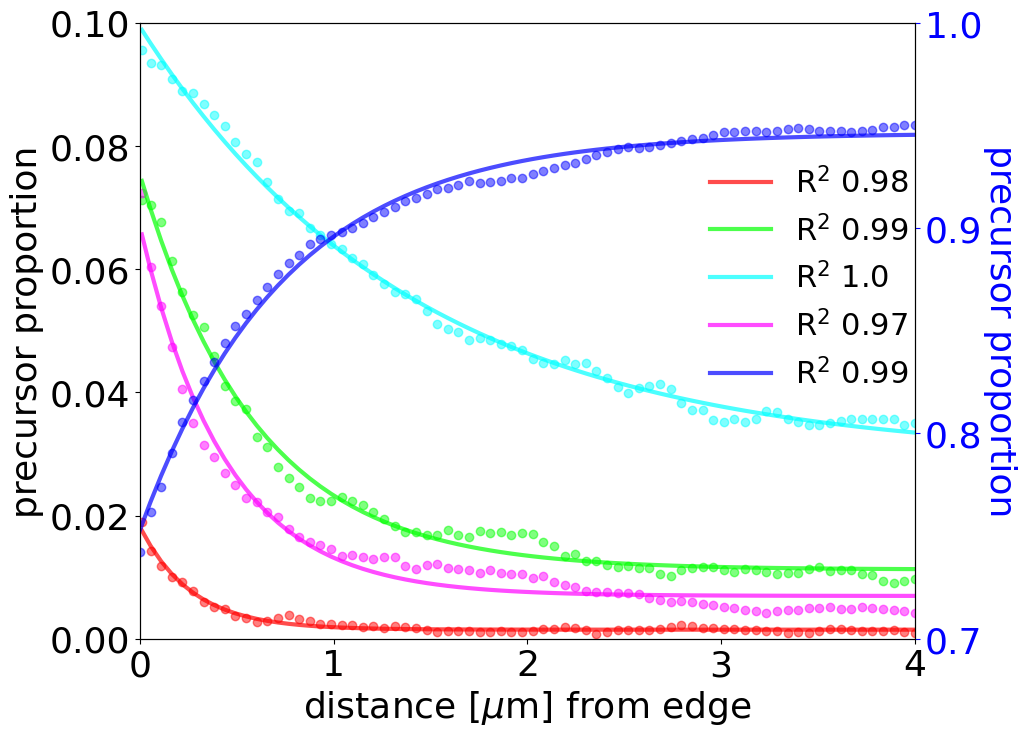

In [14]:
fig,ax = plt.subplots(1,1,figsize = (10,8),sharex=True)
S=3

twin = ax.twinx()
ax.scatter(S49_0_x, S49_0_y, color='red',alpha=.5)
ax.scatter(S49_1_x, S49_1_y, color='lime',alpha=.5)
ax.scatter(S49_2_x, S49_2_y, color='cyan',alpha=.5)
ax.scatter(S49_3_x, S49_3_y, color='magenta',alpha=.5)
twin.scatter(S49_5_x, S49_5_y, color='blue',alpha=.5)


ax.plot(S49_0_x, S49_0_fit, color='red', alpha=.7,
         label=f'R$^{2}$ {np.round(S49_0_r2, 2)}',linewidth=S)
ax.plot(S49_1_x, S49_1_fit, color='lime', alpha=.7,
         label=f'R$^{2}$ {np.round(S49_1_r2, 2)}',linewidth=S)
ax.plot(S49_2_x, S49_2_fit, color='cyan', alpha=.7,
         label=f'R$^{2}$ {np.round(S49_2_r2, 2)}',linewidth=S)
ax.plot(S49_3_x, S49_3_fit, color='magenta', alpha=.7,
         label=f'R$^{2}$ {np.round(S49_3_r2, 2)}',linewidth=S)
twin.plot(S49_5_x, S49_5_fit1,
          color='blue', alpha=.7,
         label=f'R$^{2}$ {np.round(S49_5_r21, 2)}',linewidth=S)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = twin.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
ax.legend(handles, labels, 
          framealpha=False, 
          bbox_to_anchor=(.7, .36), 
          fontsize=22)

ax.set_xlim(0,4)
ax.set_ylim(0,.10)
twin.set_ylim(.7,1)
twin.set_yticks([0.70,.8,.9,1.])
twin.tick_params(axis='y', colors='blue')

ax.set_xlabel('distance [$\mu$m] from edge')
ax.set_ylabel('precursor proportion')
twin.set_ylabel('precursor proportion',
                rotation=270, 
                labelpad = 25,
                color='blue')
plt.show()

In [15]:
##corresponding 1/e lengths
S49_0 = length_1e(S49_0_params)
S49_1 = length_1e(S49_1_params)
S49_2 = length_1e(S49_2_params)
S49_3 = length_1e(S49_3_params)
S49_5 = length_1e(S49_5_params1)
e_lengths = [S49_0,S49_1,S49_2,S49_3,S49_5]
e_lengths_labels = ['S49_0','S49_1','S49_2','S49_3','S49_5']
for name,elength in zip(e_lengths_labels,e_lengths):
    print(name, ': ', np.round(elength,2), 'micron')

S49_0 :  0.27 micron
S49_1 :  0.6 micron
S49_2 :  1.41 micron
S49_3 :  0.44 micron
S49_5 :  0.74 micron
